In [1]:
library(wesanderson)
library(purrr)
library(ggthemes)
library(bayesplot)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(cowplot)
library(ggbeeswarm)
library(tidybayes)
library(rethinking)
#set_ulam_cmdstan(TRUE)
#data(chimpanzees)
#d <- chimpanzees
#detach(package:rethinking, unload = T)
library(brms)
library(performance)

This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ readr     2.1.4     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubrida

In [2]:
theme_set(
  theme_base(base_size = 12) +
    theme(text = element_text(family = "Times"),
          axis.text = element_text(family = "Times"),
          axis.ticks = element_line(linewidth = 0.25),
          axis.ticks.length = unit(0.1, "cm"),
          panel.background = element_rect(linewidth = 0.1),
          plot.background = element_blank(),
          )
  )

In [19]:
setwd("~/Documents/post-doc/cingulata/research/crossings/")
#datalist = readRDS("modeldatasets.RDS")
datalist = readRDS("modeldatasets-usa-europe.RDS")

Load the models to variables

Models are loaded from the models folder.

In [4]:
#datalist = readRDS("modeldatasets_test.RDS")
b2.1 <- datalist$b2.1
b2.2 <- datalist$b2.2
b2.3 <- datalist$b2.3

Models 

In [ ]:
b2.1 <-
  brm(data = d, family = binomial,
      hatched | trials(egg_tot) ~ 1 + (1 | id) + pop + cross_type + continent,
      prior = c(set_prior("normal(0, 1.5)", class = "Intercept"),
                set_prior("normal(0, 1.5)", class = "b"),
                set_prior("normal(0, 1.5)", class = "b", coef = "popsame")),
      iter = 2500, warmup = 500, cores = 2, chains = 2,
      seed = 10) 

b2.2 <-
  brm(data = d, family = binomial,
      hatched | trials(egg_tot) ~ 1 + (1 | id) + pop + cross_type%in%continent,
      prior = c(set_prior("normal(0, 1.5)", class = "Intercept"),
                set_prior("normal(0, 1.5)", class = "b"),
                set_prior("normal(0, 1.5)", class = "b", coef = "popsame")),
      iter = 2500, warmup = 500, cores = 2, chains = 2,
      seed = 10)

b2.3 <-
  brm(data = d, family = binomial,
      hatched | trials(egg_tot) ~ 1 + (1 | id) + cross_type%in%pop + cross_type%in%continent, #cross_type in nested in continent
      prior = c(set_prior("normal(0, 1.5)", class = "Intercept"),
                set_prior("normal(0, 1.5)", class = "b")),
                #set_prior("normal(0, 1.5)", class = "b", coef = "popsame")),
      iter = 2500, warmup = 500, cores = 2, chains = 2,
      seed = 10) 

Europe data

`summarise()` has grouped output by 'cross_type'. You can override using the
`.groups` argument.


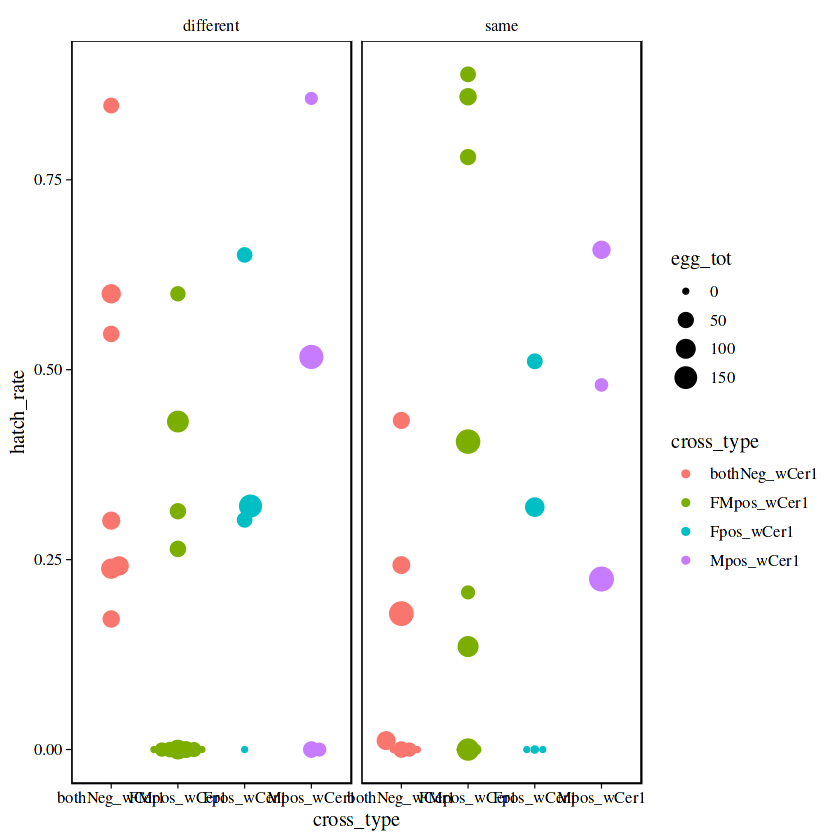

In [28]:
d.eu <- read.csv("~/Documents/post-doc/cingulata/research/crossings/crossing_data_ordered.csv", header = T, sep = ",")
# Carfefull with cage 20. Infection unknown
d.eu$hatch_rate <- d.eu$hatched/d.eu$egg_tot
d.eu[d.eu$hatch_rate == "NaN",]$hatch_rate <- 0
d.eu %>% group_by(cross_type, pop) %>% summarise(egg_tot = sum(egg_tot)) %>% write_delim(file = "egg_tot.csv", delim = ",")
d.eu %>%  group_by(cross_type) %>% dplyr::summarize(Mean = mean(hatch_rate, na.rm=TRUE)) %>% write_delim(file = "hatch_rate.csv", delim = ",")
d.eu <- d.eu %>% 
    mutate(cross_type = case_when(infection_F == 0 & infection_M == 0 ~ "bothNeg_wCer1" , # both tests: group A
                                  infection_F == 0 & infection_M == 1 ~ "Mpos_wCer1",
                                  infection_F == 1 & infection_M == 0 ~ "Fpos_wCer1",
                                  infection_F == 1 & infection_M == 1 ~ "FMpos_wCer1"

    ))

d.eu <- d.eu %>% 
    mutate(pop = case_when(population_F == population_M ~  "same", # both tests: group A
                                population_F != population_M ~  "different"
    ))

#d.eu <- d.eu %>% add_column(continent = "europe")

d.eu.egg.filter <- d.eu %>% filter(egg_tot > 5)

ENP.eu <- ggplot(d.eu, aes(x = cross_type, y = egg_tot, color = cross_type, size = egg_tot)) + geom_beeswarm(cex = 3) + facet_wrap(~pop)
HRP.eu <- ggplot(d.eu, aes(x = cross_type, y = hatch_rate, color = cross_type, size = egg_tot)) + geom_beeswarm(cex = 3) + facet_wrap(~pop)
HNP.eu <- ggplot(d.eu, aes(x = cross_type, y = hatched, color = cross_type, size = egg_tot)) + geom_beeswarm(cex = 3) + facet_wrap(~pop)
#plot_grid(ENP.eu, HNP.eu, HRP.eu)
plot_grid(HRP.eu)

In [29]:
d.eu

X,population_F,population_M,id,infection_F,infection_M,egg_tot,hatched,hatch_rate,cross_type,pop,continent
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>
1,215120,215120,2,0,1,196,44,0.22448980,Mpos_wCer1,same,europe
2,215120,215120,8,0,0,190,34,0.17894737,bothNeg_wCer1,same,europe
3,237520,237520,29,1,1,185,75,0.40540541,FMpos_wCer1,same,europe
4,232620,234620,31,0,1,178,92,0.51685393,Mpos_wCer1,different,europe
5,232620,237520,25,1,0,156,50,0.32051282,Fpos_wCer1,different,europe
6,232620,232620,32,1,1,143,0,0.00000000,FMpos_wCer1,same,europe
7,232620,234620,30,1,1,132,57,0.43181818,FMpos_wCer1,different,europe
8,232620,232620,33,1,1,118,16,0.13559322,FMpos_wCer1,same,europe
9,232620,237520,39,0,0,105,25,0.23809524,bothNeg_wCer1,different,europe


USA data

pop,Mean
<chr>,<dbl>
different,0.2894437
same,0.3837714


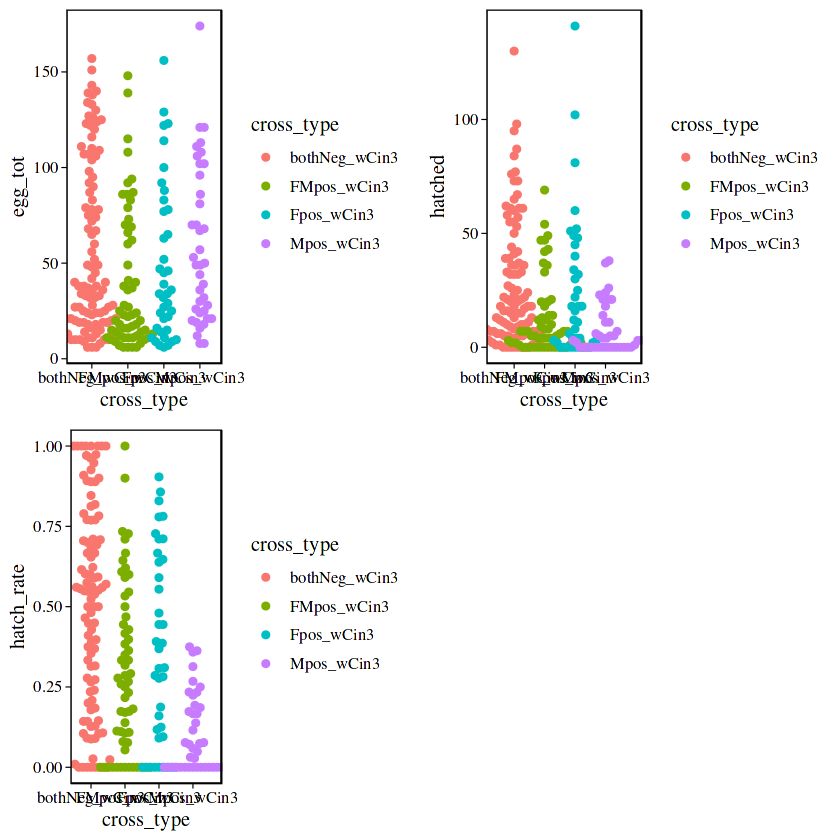

In [30]:
d.usa <- read.csv("crossing_assay_data_usa.csv", header = T, sep = ",")
#d.usa.parental <- d.usa %>% filter(cross.type == "parental")
#d.usa.hybrid <- d.usa %>% filter(cross.type == "hybrid")
d.usa %>%  group_by(pop) %>% dplyr::summarize(Mean = mean(hatch_rate, na.rm=TRUE))

d.usa <- d.usa %>% add_column(continent = "usa")
#d.usa <- d.usa %>% drop_na()
#d.usa <- d.usa %>% subset(pop != "different")

d.usa <- d.usa %>% 
    mutate(cross_type = case_when(population_F != "SW" & population_M != "SW" ~ "bothNeg_wCin3" , # both tests: group A
                                  population_F != "SW" & population_M == "SW" ~ "Mpos_wCin3",
                                  population_F == "SW" & population_M != "SW" ~ "Fpos_wCin3",
                                  population_F == "SW" & population_M == "SW" ~ "FMpos_wCin3"
                                  #infection_F && infection_M ~ "both_neg",
                                  #infection_F && infection_M ~ "both_neg"
                             #xor(test1, test2) ~ "B", # one test: group B
                             #!test1 & !test2 ~ "C" # neither test: group C
    ))

d.usa.egg.filter <- d.usa %>% filter(egg_tot > 5)

ENP.usa <- ggplot(d.usa.egg.filter, aes(x = cross_type, y = egg_tot, color = cross_type)) + geom_beeswarm(cex = 3)
HRP.usa <- ggplot(d.usa.egg.filter, aes(x = cross_type, y = hatch_rate, color = cross_type)) + geom_beeswarm(cex = 3)
HNP.usa <- ggplot(d.usa.egg.filter, aes(x = cross_type, y = hatched, color = cross_type)) + geom_beeswarm(cex = 3)
plot_grid(ENP.usa, HNP.usa, HRP.usa)

Join the two datasets

In [35]:
d.eu <- d.eu %>%
    mutate(population_F = as.character(population_F), population_M = as.character(population_M), id = as.character(id)) %>%
    type_convert(cols(population_F = "c", population_M = "c", id = "c")) %>% as_tibble()

d <- bind_rows(d.eu, d.usa)

a <- d |> group_by(cross_type, continent, pop) |> summarise(egg_tot = sum(egg_tot)) %>% write_delim(file = "egg_tot_summary.csv", delim = ",")
b <- d |> group_by(cross_type, continent, pop) |> count(cross_type) %>% write_delim(file = "cross_type_summary.csv", delim = ",")
a
b
d %>% write_delim(file = "raw-crossing-data.csv", delim = ",")

`summarise()` has grouped output by 'cross_type', 'continent'. You can override
using the `.groups` argument.


cross_type,continent,pop,egg_tot
<chr>,<chr>,<chr>,<int>
FMpos_wCer1,europe,different,545
FMpos_wCer1,europe,same,641
FMpos_wCin3,usa,same,2332
Fpos_wCer1,europe,different,242
Fpos_wCer1,europe,same,140
Fpos_wCin3,usa,different,1939
Mpos_wCer1,europe,different,282
Mpos_wCer1,europe,same,297
Mpos_wCin3,usa,different,2289


cross_type,continent,pop,n
<chr>,<chr>,<chr>,<int>
FMpos_wCer1,europe,different,11
FMpos_wCer1,europe,same,9
FMpos_wCin3,usa,same,115
Fpos_wCer1,europe,different,4
Fpos_wCer1,europe,same,5
Fpos_wCin3,usa,different,60
Mpos_wCer1,europe,different,4
Mpos_wCer1,europe,same,3
Mpos_wCin3,usa,different,54


Warning message:
“Removed 73 rows containing missing values (`geom_point()`).”


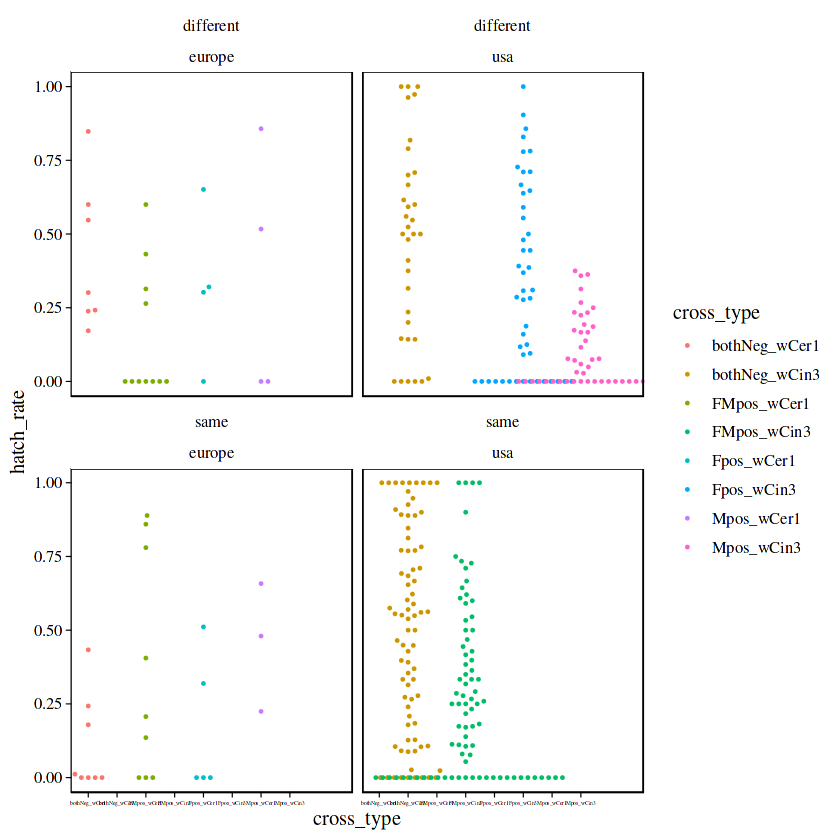

In [60]:
ggplot(d, aes(x = cross_type, y = hatch_rate, color = cross_type)) + geom_beeswarm(cex = 3, size = 0.3) + facet_wrap(~pop*continent) + theme(axis.text.x = element_text(size = 3))   

Warning message:
“
256 (62.6%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“
248 (60.6%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“
254 (62.1%) p_waic estimates greater than 0.4. We recommend trying loo instead.”


     elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic waic   se_waic
b2.2    0.0       0.0  -689.7      24.8        150.3    4.5    1379.5   49.6 
b2.1   -2.2       1.1  -691.9      24.9        152.2    4.5    1383.8   49.7 
b2.3   -3.7       1.3  -693.4      24.9        153.3    4.6    1386.9   49.8 


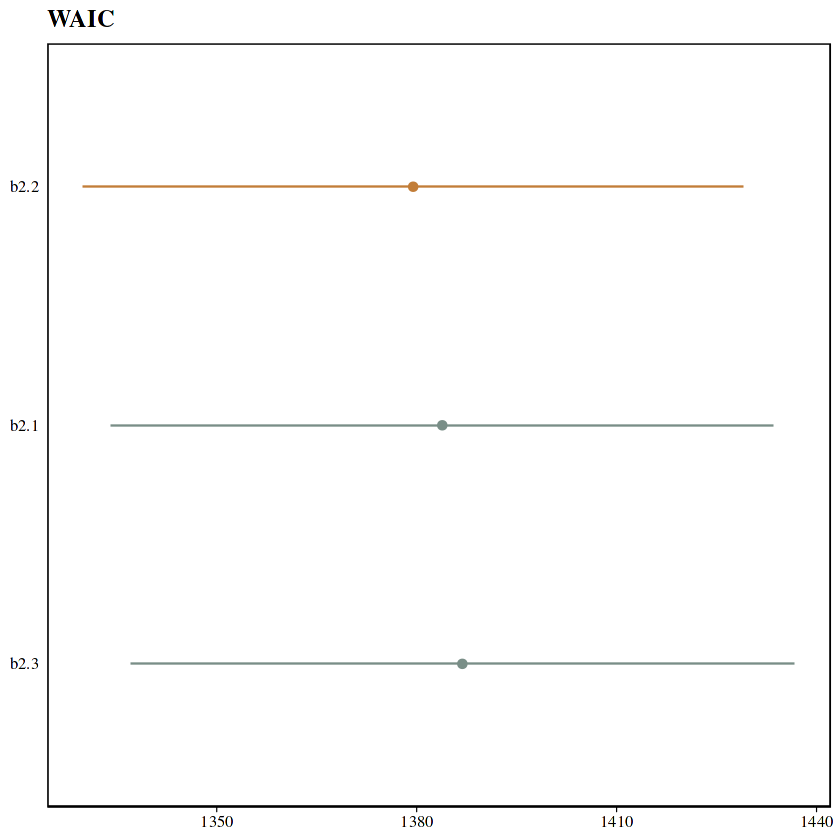

In [8]:
b2.1 <- add_criterion(b2.1, "waic")
b2.2 <- add_criterion(b2.2, "waic")
b2.3 <- add_criterion(b2.3, "waic")

w <- loo_compare(b2.1, b2.2, b2.3, criterion = "waic")

print(w, simplify = F)

w %>% 
  data.frame() %>% 
  rownames_to_column(var = "model") %>%
  
  ggplot(aes(x = reorder(model, -waic), 
             y    = waic,
             ymin = waic - se_waic,
             ymax = waic + se_waic,
             color = model)) +
  geom_pointrange(shape = 16, show.legend = F) +
  scale_color_manual(values = wes_palette("Moonrise2")[c(1, 2, 1, 1, 1, 2)]) +
  coord_flip() +
  labs(x = NULL, y = NULL,
       title = "WAIC") +
  theme(axis.ticks.y    = element_blank())

Setting all 'trials' variables to 1 by default if not specified otherwise.



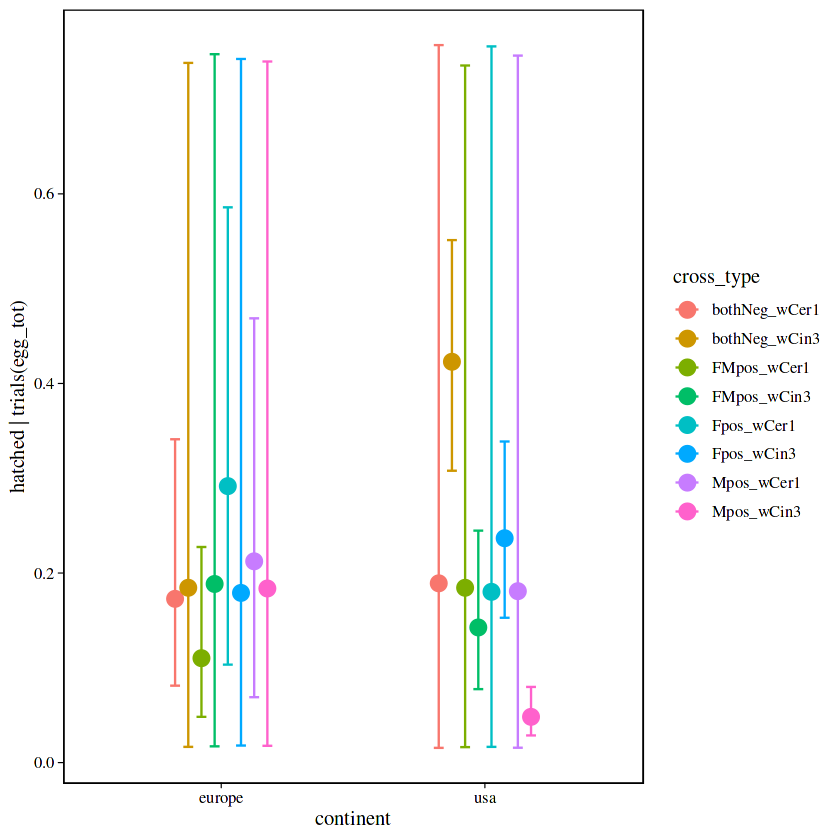

In [9]:
continent <- data.frame(continent = c("europe", "usa"))
condition <- data.frame(continent = c("europe", "usa"))
condition_continent <- data.frame(continent = c("europe", "usa"), pop = c("same", "different"))
condition_pop <- data.frame(pop = c("same", "different"))
condition_type <- data.frame(cross_type = c("same", "different"))

conditional_effects(b2.2, effects = "continent:cross_type", prob = 0.89, points = T)
#conditional_effects(b2.1, effects = "pop", prob = 0.89, points = T)

Warning message:
“Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives.”


Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


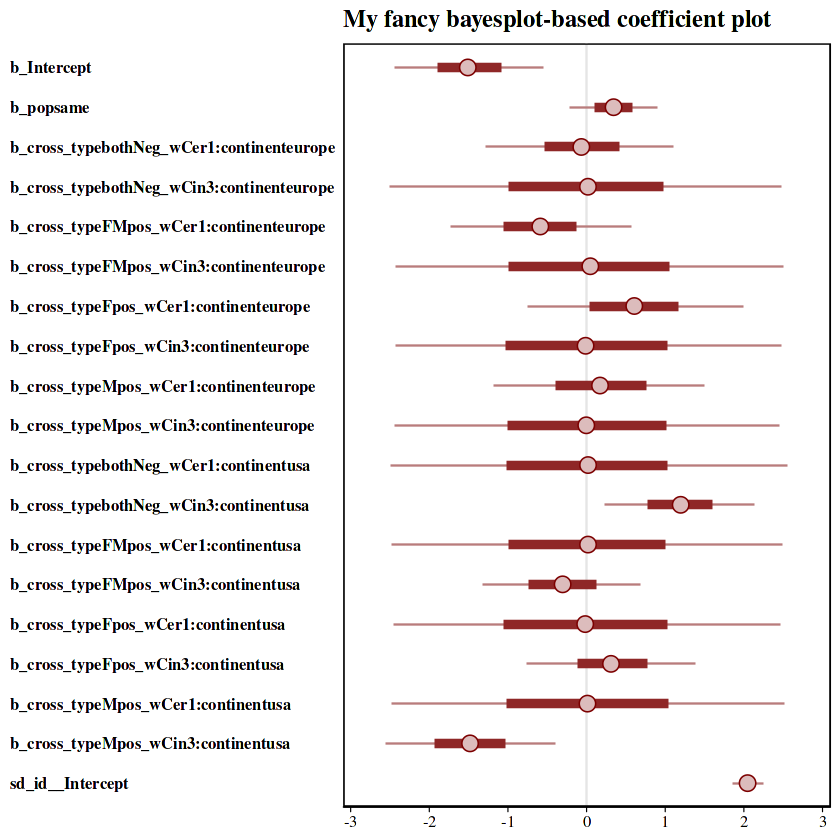

In [10]:
post <- posterior_samples(b2.2)

color_scheme_set("red")
mcmc_intervals(post[, 1:19], 
               prob = .5,
               point_est = "median") +
  labs(title = "My fancy bayesplot-based coefficient plot") +
  theme(axis.text.y  = element_text(hjust = 0),
        axis.line.x  = element_line(size = 1/4),
        axis.line.y  = element_blank(),
        axis.ticks.y = element_blank())

In [11]:
#as_draws_df(b2.2) %>% colnames()
col_pickup <- c('b_Intercept','b_cross_typebothNeg_wCin3','b_cross_typeFMpos_wCer1','b_cross_typeFMpos_wCin3','b_cross_typeFpos_wCer1','b_cross_typeFpos_wCin3','b_cross_typeMpos_wCer1','b_cross_typeMpos_wCin3')
post2.1 <- as_draws_df(b2.1) %>% #select(all_of(col_pickup)) %>% 
pivot_longer(col_pickup[2:length(col_pickup)])%>%
  mutate(continent = case_when(
    endsWith(name, "europe") ~ "europe",
    endsWith(name, "usa") ~ "usa"
    )) %>%
  mutate(cross_type= case_when(
    startsWith(name, "b_cross_typebothNeg") ~ "bothNeg",
    startsWith(name, "b_cross_typeFMpos") ~ "FMpos",
    startsWith(name, "b_cross_typeFpos") ~ "Fpos",
    startsWith(name, "b_cross_typeMpos") ~ "Mpos"
    )) %>%
  mutate(strain = case_when(
    grepl("*wCer1*", name) ~ "wCer1",
    grepl("*wCin3*", name) ~ "wCin3"
  ))


Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


In [12]:
#col_pickup <- c('b_Intercept','b_cross_typebothNeg_wCer1:continenteurope','b_cross_typebothNeg_wCin3:continenteurope','b_cross_typeFMpos_wCer1:continenteurope','b_cross_typeFMpos_wCin3:continenteurope','b_cross_typeFpos_wCer1:continenteurope','b_cross_typeFpos_wCin3:continenteurope','b_cross_typeMpos_wCer1:continenteurope','b_cross_typeMpos_wCin3:continenteurope','b_cross_typebothNeg_wCer1:continentusa','b_cross_typebothNeg_wCin3:continentusa','b_cross_typeFMpos_wCer1:continentusa','b_cross_typeFMpos_wCin3:continentusa','b_cross_typeFpos_wCer1:continentusa','b_cross_typeFpos_wCin3:continentusa','b_cross_typeMpos_wCer1:continentusa','b_cross_typeMpos_wCin3:continentusa')
col_pickup <- c('b_Intercept','b_popsame','b_cross_typebothNeg_wCer1:continenteurope','b_cross_typeFMpos_wCer1:continenteurope','b_cross_typeFpos_wCer1:continenteurope','b_cross_typeMpos_wCer1:continenteurope','b_cross_typebothNeg_wCin3:continentusa','b_cross_typeFMpos_wCin3:continentusa','b_cross_typeFpos_wCin3:continentusa','b_cross_typeMpos_wCin3:continentusa')
post2.2 <- as_draws_df(b2.2) %>% select(all_of(col_pickup)) %>%
pivot_longer(col_pickup[3:length(col_pickup)])%>%
  mutate(continent = case_when(
    endsWith(name, "europe") ~ "europe",
    endsWith(name, "usa") ~ "usa"
    )) %>%
  mutate(cross_type= case_when(
    startsWith(name, "b_cross_typebothNeg") ~ "bothNeg",
    startsWith(name, "b_cross_typeFMpos") ~ "FMpos",
    startsWith(name, "b_cross_typeFpos") ~ "Fpos",
    startsWith(name, "b_cross_typeMpos") ~ "Mpos"
    )) %>%
  mutate(strain = case_when(
    grepl("*wCer1*", name) ~ "wCer1",
    grepl("*wCin3*", name) ~ "wCin3"
  ))

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


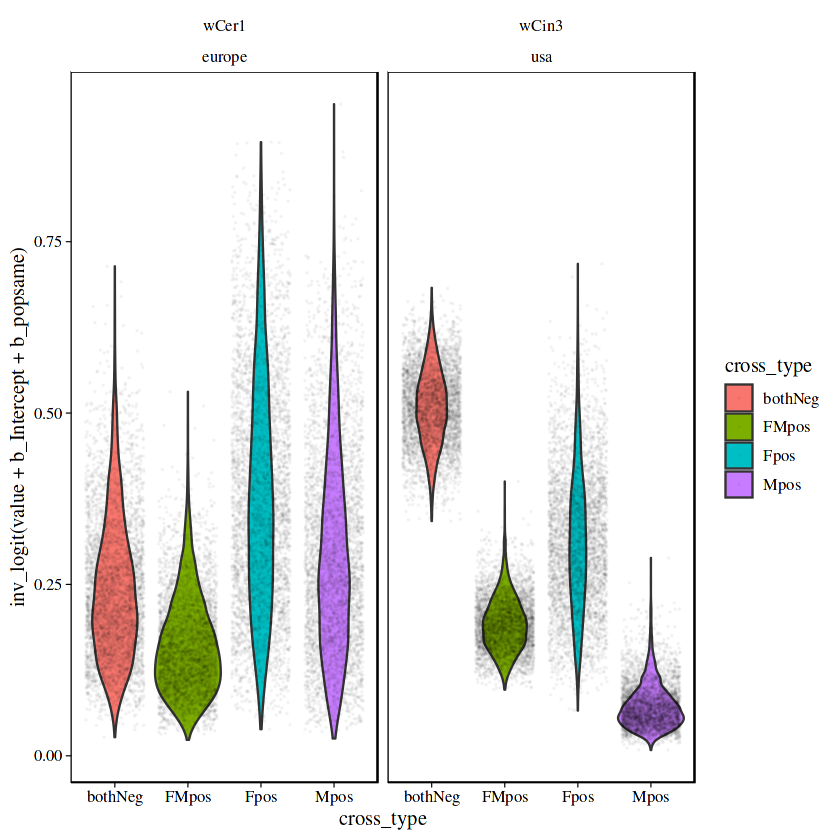

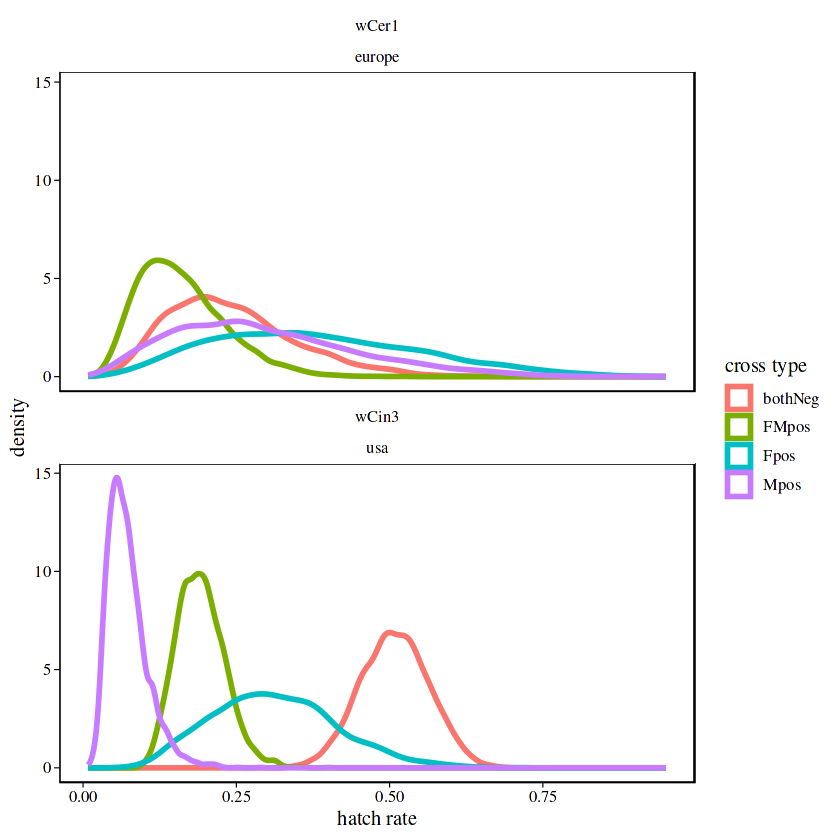

In [13]:
#post <- as_draws_df(b2.2) %>% select(all_of(col_pickup)) %>% 
#pivot_longer(col_pickup) %>% rename(cross_type = name) %>% add_column(data_type = "simulated")
#full <- left_join(post, d)
#full
ggplot(data = post2.2, aes(x=cross_type, y=inv_logit(value+b_Intercept+b_popsame), fill=cross_type)) +
    geom_violin() + 
    geom_jitter(color="black", size=0.004, alpha=0.03) + #geom_beeswarm(data = d, aes(x=cross_type, y=hatched/egg_tot, size = egg_tot), color = "red", cex= 3) +
    facet_wrap(~strain*continent, ncol = 2)

ggplot(data = post2.2, aes(x = inv_logit(value+b_Intercept+b_popsame), color=cross_type)) +
  geom_density(lwd = 1.2, linetype = 1, alpha = 0.9) + labs(colour = "cross type", x = "hatch rate") + facet_wrap(~strain*continent, nrow = 2)
  #scale_color_manual(values = cols)

Hypothesis,Estimate,Est.Error,CI.Lower,CI.Upper,Evid.Ratio,Post.Prob,Star
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
qe1,0.5274717,0.7419004,-0.931360161,2.0398434,NA,NA,
qe2,-0.6706400,0.9244854,-2.475276031,1.1537712,NA,NA,
qe3,-0.2342358,0.9402449,-2.079149940,1.6311408,NA,NA,
qe4,-1.1981117,0.9274410,-3.029100182,0.6216971,NA,NA,
qe5,-0.7617076,0.8931089,-2.449538999,1.0049518,NA,NA,
qe6,0.4364042,1.0331774,-1.546399320,2.4848736,NA,NA,
qu1,1.4918738,0.3321630,0.836323355,2.1456763,NA,NA,*
qu2,0.8662857,0.4639889,-0.002782266,1.8451054,NA,NA,
qu3,2.6742155,0.4566740,1.764530308,3.5611162,NA,NA,*


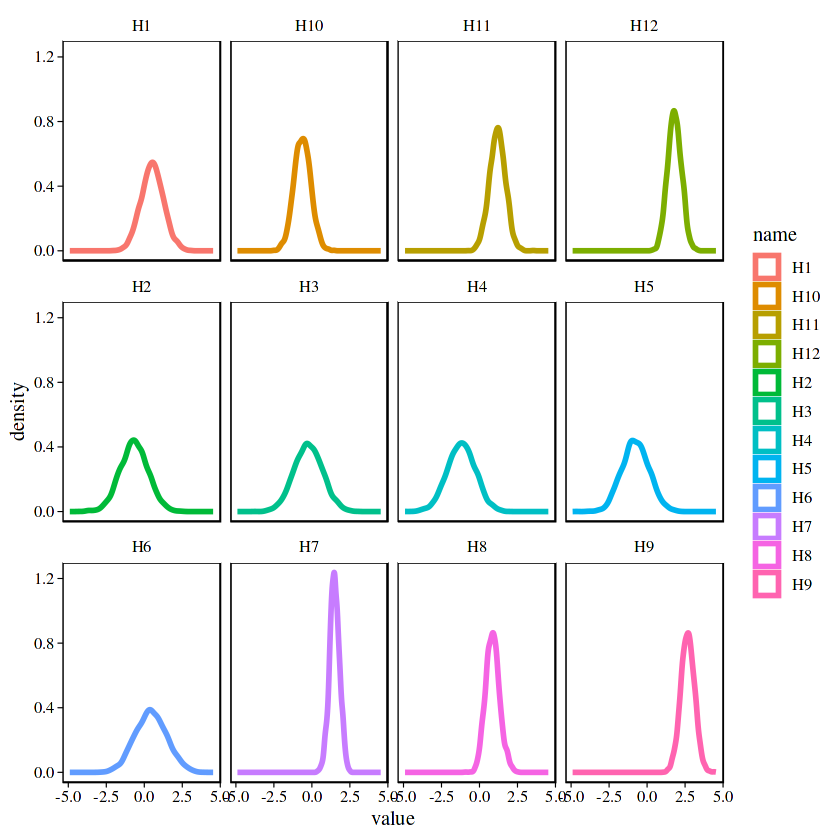

In [36]:
qe1 <- c(qe1 = "cross_typebothNeg_wCer1:continenteurope + popsame + Intercept = cross_typeFMpos_wCer1:continenteurope + popsame + Intercept")
qe2 <- c(qe2 = "cross_typebothNeg_wCer1:continenteurope + popsame + Intercept  = cross_typeFpos_wCer1:continenteurope + popsame + Intercept")
qe3 <- c(qe3 = "cross_typebothNeg_wCer1:continenteurope + popsame + Intercept  = cross_typeMpos_wCer1:continenteurope + popsame + Intercept")
qe4 <- c(qe4 = "cross_typeFMpos_wCer1:continenteurope + popsame + Intercept = cross_typeFpos_wCer1:continenteurope + popsame + Intercept")
qe5 <- c(qe5 = "cross_typeFMpos_wCer1:continenteurope + popsame + Intercept = cross_typeMpos_wCer1:continenteurope + popsame + Intercept")
qe6 <- c(qe6 = "cross_typeFpos_wCer1:continenteurope + popsame + Intercept = cross_typeMpos_wCer1:continenteurope + popsame + Intercept")

qu1 <- c(qu1 = "cross_typebothNeg_wCin3:continentusa + popsame + Intercept = cross_typeFMpos_wCin3:continentusa + popsame + Intercept")
qu2 <- c(qu2 = "cross_typebothNeg_wCin3:continentusa + popsame + Intercept  = cross_typeFpos_wCin3:continentusa + popsame + Intercept")
qu3 <- c(qu3 = "cross_typebothNeg_wCin3:continentusa + popsame + Intercept  = cross_typeMpos_wCin3:continentusa + popsame + Intercept")
qu4 <- c(qu4 = "cross_typeFMpos_wCin3:continentusa+ popsame + Intercept = cross_typeFpos_wCin3:continentusa + popsame + Intercept")
qu5 <- c(qu5 = "cross_typeFMpos_wCin3:continentusa + popsame+ Intercept = cross_typeMpos_wCin3:continentusa + popsame + Intercept")
qu6 <- c(qu6 = "cross_typeFpos_wCin3:continentusa + popsame + Intercept = cross_typeMpos_wCin3:continentusa + popsame + Intercept")

hyp <- hypothesis(b2.2, c(qe1, qe2, qe3, qe4, qe5, qe6, qu1, qu2, qu3, qu4, qu5, qu6))

hyp_table <- hyp$hypothesis %>% slice(rep(1:n(), nrow(hyp$samples)))
hyp_table
hyp_long <- hyp$samples %>% pivot_longer(c(H1, H2, H3, H4, H5, H6, H7, H8, H9, H10, H11, H12))

hyp_long <- cbind(hyp_long, hyp_table)

ggplot(data = hyp_long, aes(x = value, color = name)) +
  geom_density(lwd = 1.2, linetype = 1, alpha = 0.9) +
  facet_wrap(~name)
  #geom_segment(data = hyp_long,
  #             aes(x = CI.Lower	, xend = CI.Upper	, y = 0, yend = value), linetype = "dashed", add = TRUE)
